In [8]:
from color_code_2 import color_code
from PIL import Image
from matplotlib.pyplot import imshow
import webcolors as wc
import colorsys

In [12]:
class Note:
    """ Note class holds all information for one MIDI note
        Attributes:
            pitch    (0:127): pitch of note on keyboard
            velocity (0:127): amplitude/loudness of note
            channel  (0:127): how far left/right in the mix a note is
    """
    def __init__(self, velocity, pitch, channel):
        self.pitch = pitch
        self.velocity = velocity
        self.channel = channel
        assert 0 <= pitch <= 127,    "Pitch must be between 0 and 127"
        assert 0 <= velocity <= 127, "Velocity must be between 0 and 127"
        assert 0 <= channel <= 127,  "Velocity must be between 0 and 127"


class Genre:
    """ Holds a genre as an integer
    """
    def __init__(self, g):
        self.possible_genres = {0: 'class', 1: 'pop', 2: 'r&b', 3: 'folk',
                                4: 'hiphop', 5: 'edm', 6: 'rock', 7: 'blues', 8: 'default'}
        if type(g) is int:
            self.genre = self.possible_genres[g]
        else:
            self.genre = g
        assert self.genre in self.possible_genres.values(), "Genre does not exist"
        self.colors = color_code[self.genre]

    def get_genre_name(self, genre_num):
        """ returns genre name given the genre number """
        assert genre_num in self.possible_genres.keys(), "unknown genre"
        return self.possible_genres(genre_num)
    
class Frame:
    """ Holds a list of notes and a genre. Instances of this class are 
        what is output by the machine learning code 
        Params:
            notes (list) : list of Note objects
            genre (Genre): single genre
    """

    def __init__(self, notes, genre):
        self.notes = notes
        assert type(notes[0]) is Note, "notes should be an array of type `Note`"
        self.genre = genre
        assert type(genre) is Genre, "genre should be of type Genre"

In [103]:
class Cube:
    """
    Maps a frame to cube indices and colors and provides methods to pass
    this info to the Arduino controlling the cube
    """
    def __init__(self, size):
        """ Creates a new cube based on a size
        """
        self.size   = size
        self.matrix = [[["#000000" for x in range(size)] for y in range(size)] for z in range(size)]
        
    def clear(self):
        """ reset all colors to zeros
        """
        self.matrix = [[["#000000" for x in range(self.size)] for y in range(self.size)] for z in range(self.size)]
        
    def get_xyz(self, note):
        """ gets x, y, z values given a Note object
            x: left/right value
            y: octave
            z: stack of notes
        """
        # channel is float 0-127, convert to int 0-self.size
        x = int(note.channel // (127 / self.size))
        
        # display from octave 1 up to size of cube in octaves
        # return None if y invalid (out of range)
        y = int((note.pitch-12) // 12) if 12 <= note.pitch < (self.size+1)*12 else None
        if y is None or x is None:
            return None
        z = self.matrix[x][y].index("#000000")
        if z is None:
            return None
        return (x, y, z)
    
    def get_color(self, genre, note):
        """ Gets color for note based on genre
            TODO: hold color codes in genre class, access from there
            TODO: fix color codes so brightness based on velocity
        """
        note_in_octave = note.pitch%12
        try:
            hex_code = "#"+genre.colors[note_in_octave]
            hls = list(colorsys.rgb_to_hls(*wc.hex_to_rgb(hex_code)))
            # update lightness based on velocity but from 0-255
            hls[1] = note.velocity * 2
            rgb = colorsys.hls_to_rgb(*[int(round(x)) for x in hls])
            #wc.rgb_to_hex([int(x) for x in rgb])
            return hex_code
        except Exception as E:
            return "#000000"
        
    def display_screen(self, layer, swatch_size=10):
        img = Image.new("RGB", (swatch_size*self.size,swatch_size*self.size))
        for x in range(self.size):
             for y in range(self.size):
                    img.paste(self.matrix[x][y][layer], (x*swatch_size, y*swatch_size, (x+1)*swatch_size, (y+1)*swatch_size))
        return img.transpose(Image.FLIP_TOP_BOTTOM)
    
    def process_frame(self, frame):
        """ Updates cube with new frame information
            Steps:
                + Clear cube
                + For each note
                    + get x,y,z position (0-5 in each access)
                    + get color
                    + update color for index of matrix
        """
        self.clear()
        for note in frame.notes:
            try:
                x, y, z = self.get_xyz(note)
            except:
                continue
            color = self.get_color(frame.genre, note)
            #print(f"{x}, {y}, {z}, {color}")
            self.matrix[x][y][z] = color
        

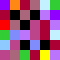

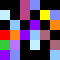

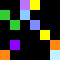

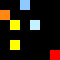

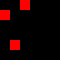

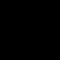

[None, None, None, None, None, None]

In [107]:
from random import randint

#notes = [Note(40, 83, 10), Note(87, 19, 121), Note(20, 51, 64)]
notes = [Note(randint(10,127),i,randint(0,127)) for i in range(12, 127)]
f = Frame(notes, Genre('default'))

c = Cube(6)

c.process_frame(f)

[display(c.display_screen(i)) for i in range(c.size)]